In [1]:
import pandas as pd

train = pd.read_csv('data/lab4/train.csv')
test = pd.read_csv('data/lab4/test.csv')

In [2]:
train.info()

<class 'pandas.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   id         750000 non-null  int64
 1   age        750000 non-null  int64
 2   job        750000 non-null  str  
 3   marital    750000 non-null  str  
 4   education  750000 non-null  str  
 5   default    750000 non-null  str  
 6   balance    750000 non-null  int64
 7   housing    750000 non-null  str  
 8   loan       750000 non-null  str  
 9   contact    750000 non-null  str  
 10  day        750000 non-null  int64
 11  month      750000 non-null  str  
 12  duration   750000 non-null  int64
 13  campaign   750000 non-null  int64
 14  pdays      750000 non-null  int64
 15  previous   750000 non-null  int64
 16  poutcome   750000 non-null  str  
 17  y          750000 non-null  int64
dtypes: int64(9), str(9)
memory usage: 103.0 MB


In [3]:
train.drop(columns="id")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [4]:
train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='str')

In [5]:
train.isna().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [6]:
import category_encoders

encoder = category_encoders.OrdinalEncoder(cols=['job', 'marital', 'default', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome'])

train_encoded = encoder.fit_transform(train)

train_encoded.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,1,1,1,1,7,1,1,1,25,1,117,3,-1,0,1,0
1,1,38,2,1,1,1,514,1,1,2,18,2,185,1,-1,0,1,0
2,2,36,2,1,1,1,602,2,1,2,14,3,111,2,-1,0,1,0
3,3,27,3,2,1,1,34,2,1,2,28,3,10,2,-1,0,1,0
4,4,26,1,1,1,1,889,2,1,1,3,4,902,1,-1,0,1,1


Training Logistic Regression...
Training Random Forest...
Training SGD Classifier...
Training XGBoost...
Training CatBoost...


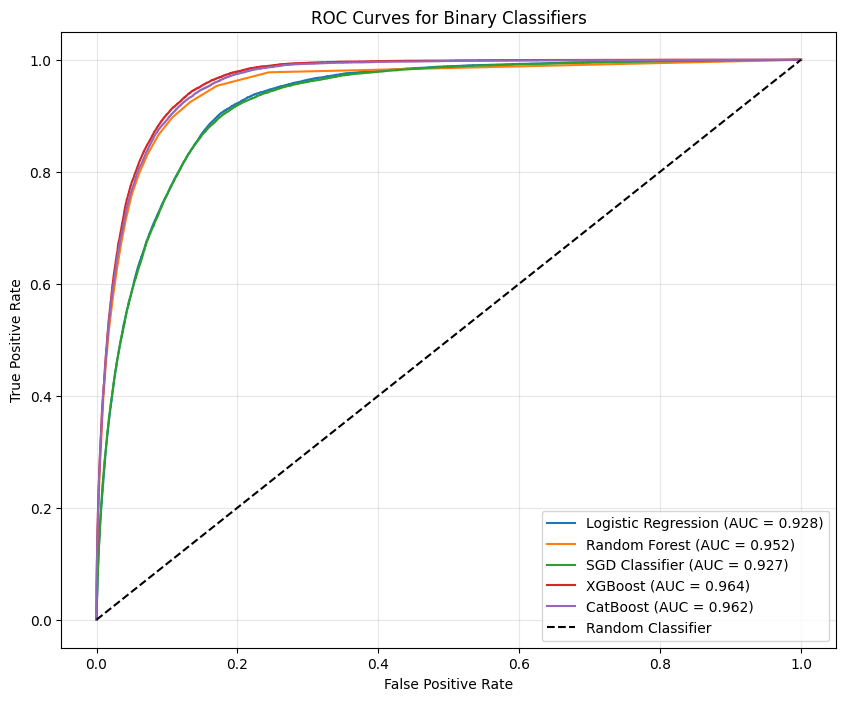

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

# Prepare data
X = train_encoded.drop(columns=['id', 'y'])
y = train_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train multiple classifiers with optimizations
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=20, random_state=42),
    'SGD Classifier': SGDClassifier(loss='log_loss', random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=50, random_state=42, verbosity=0),
    'CatBoost': CatBoostClassifier(iterations=50, random_state=42, verbose=0)
}

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classifiers')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [8]:
test.info()

<class 'pandas.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   id         250000 non-null  int64
 1   age        250000 non-null  int64
 2   job        250000 non-null  str  
 3   marital    250000 non-null  str  
 4   education  250000 non-null  str  
 5   default    250000 non-null  str  
 6   balance    250000 non-null  int64
 7   housing    250000 non-null  str  
 8   loan       250000 non-null  str  
 9   contact    250000 non-null  str  
 10  day        250000 non-null  int64
 11  month      250000 non-null  str  
 12  duration   250000 non-null  int64
 13  campaign   250000 non-null  int64
 14  pdays      250000 non-null  int64
 15  previous   250000 non-null  int64
 16  poutcome   250000 non-null  str  
dtypes: int64(8), str(9)
memory usage: 32.4 MB


In [9]:
cols = test.select_dtypes(include=['object']).columns
encoder = category_encoders.OrdinalEncoder(cols=cols)
test_encoded = encoder.fit_transform(test)

C:\Users\sumed\AppData\Local\Temp\ipykernel_1088\533545350.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cols = test.select_dtypes(include=['object']).columns


In [10]:
test_encoded.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,1,1,1,1,1397,1,1,1,21,1,224,1,-1,0,1
1,750001,44,2,1,2,1,23,1,1,2,3,2,586,2,-1,0,1
2,750002,36,3,1,3,1,46,1,2,2,13,1,111,2,-1,0,1
3,750003,58,1,1,1,1,-1380,1,2,1,29,1,125,1,-1,0,1
4,750004,28,4,2,1,1,1950,1,1,2,22,3,181,1,-1,0,1


In [11]:
test_encoded.isna().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

In [12]:
scaler = StandardScaler()
test_encoded_scaled = scaler.fit_transform(test_encoded.drop(columns=['id']))


In [13]:
clf = xgb.XGBClassifier(n_estimators=50, random_state=42, verbosity=0)

In [14]:
clf.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [15]:
temp = clf.predict(test_encoded_scaled)
temp

array([0, 1, 0, ..., 0, 0, 0], shape=(250000,))

In [16]:
submission = pd.DataFrame({'id' : test_encoded['id'], 'y' : temp})
submission.to_csv('submission.csv', index=False)